# Laboratorio 2: Armado de un esquema de aprendizaje automático
## Autor: Sofia Lujan

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import takewhile
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from ml.visualization import plot_confusion_matrix, plot_learning_curve
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection

import graphviz
%matplotlib inline

np.random.seed(0)  # Para mayor determinismo

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [24]:
dataset = pd.read_csv("./data/loan_data.csv", comment="#")


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

#### 1.1. ¿De qué se trata el conjunto de datos?

A partir de los comentarios que están incluidos en el dataset:

In [25]:
with open('./data/loan_data.csv', 'r') as fobj:
    # takewhile returns an iterator over all the lines 
    # that start with the comment string
    headiter = takewhile(lambda s: s.startswith('#'), fobj)
    # you may want to process the headers differently, 
    # but here we just convert it to a list
    header = list(headiter)

In [26]:
seperator = ''
print(seperator.join(header))

# Loan dataset based on the Kaggle Home Equity dataset
# Available at: https://www.kaggle.com/ajay1735/hmeq-data
#
# Context
# =======
# The consumer credit department of a bank wants to automate the decisionmaking
# process for approval of home equity lines of credit. To do this, they will
# follow the recommendations of the Equal Credit Opportunity Act to create an
# empirically derived and statistically sound credit scoring model. The model
# will be based on data collected from recent applicants granted credit through
# the current process of loan underwriting. The model will be built from
# predictive modeling tools, but the created model must be sufficiently
# interpretable to provide a reason for any adverse actions (rejections).
#
# Content
# =======
# The Home Equity dataset (HMEQ) contains baseline and loan performance
# information for 5,960 recent home equity loans. The target (BAD) is a binary
# variable indicating whether an applicant eventually defaulted or was
# serious

Se puede concluir los siguientes puntos:
* El objetivo es automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria.
* El dataset contiene la linea de base y rendimiento del prestamo de 5960 de préstamos hipotecarios recientes.


#### 1.2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
La variable objetivo es TARGET. Es una variable etiqueta binaria, en donde el 1 indica que el solicitante incumplió con el préstamo o está gravemente moroso y el 0 indica que el préstamo ha sido pagado por el solicitante. El objetivo es automatizar el proceso de toma de decisiones para la aprobación de líneas de crédito con garantía hipotecaria, por lo cual esto indica si se da el crédito o no.


#### 1.3. ¿Qué información (atributos) hay disponible para hacer la predicción?

* LOAN    Importe de la solicitud de préstamo
* MORTDUE Monto adeudado en la hipoteca existente
* VALUE   Valor de la propiedad actual
* YOJ     Años en el trabajo actual
* DEROG   Número de informes despectivos 
* DELINQ  Número de líneas de crédito morosas
* CLAGE   Edad de la línea comercial más antigua en meses.
* NINQ    Número de líneas de crédito recientes
* CLNO    Número de líneas de crédito
* DEBTINC Relación deuda / ingresos

#### 1.4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

El target debería tener fuerte correlación con el número de informes despectivos (DEROG), el número de líneas de créditos morosas (DELINQ) y la relación deuda/ingresos (DEBTINC) ya que estas determinarían un target 1 (solicitante incumplió con el préstamo o está gravemente moroso). Para confirmar dicha hipótesis se realizó un tabla de correlación, se concluyé que la variable target tiene correlación con las variables mencionadas anteriormente.

In [27]:
corr = dataset.corr()

corr.style.background_gradient(cmap='coolwarm')

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
TARGET,1,-0.0422491,-0.0233245,-0.0354566,-0.0790034,0.28137,0.318346,-0.158654,0.138429,0.0251407,0.266687
LOAN,-0.0422491,1,0.287783,0.405931,0.121605,-0.0374645,-0.0528645,0.0698162,0.0144737,0.0778834,0.148538
MORTDUE,-0.0233245,0.287783,1,0.870438,-0.0880036,-0.046021,-0.0372568,0.137734,0.0380411,0.313263,0.196496
VALUE,-0.0354566,0.405931,0.870438,1,0.000459835,-0.0406974,-0.0511534,0.211303,-0.00453597,0.209675,0.144466
YOJ,-0.0790034,0.121605,-0.0880036,0.000459835,1,-0.0652084,0.0314129,0.205617,-0.062207,-0.0042556,-0.0701279
DEROG,0.28137,-0.0374645,-0.046021,-0.0406974,-0.0652084,1,0.158896,-0.0841309,0.201062,0.0873203,0.0536293
DELINQ,0.318346,-0.0528645,-0.0372568,-0.0511534,0.0314129,0.158896,1,0.0121804,0.0270821,0.131321,0.0654449
CLAGE,-0.158654,0.0698162,0.137734,0.211303,0.205617,-0.0841309,0.0121804,1,-0.134256,0.185443,-0.0770054
NINQ,0.138429,0.0144737,0.0380411,-0.00453597,-0.062207,0.201062,0.0270821,-0.134256,1,0.0838972,0.124341
CLNO,0.0251407,0.0778834,0.313263,0.209675,-0.0042556,0.0873203,0.131321,0.185443,0.0838972,1,0.146505


## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


In [28]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

C:\Users\soluj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

C:\Users\soluj\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Reporte de clasificación  (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       313
           1       1.00      0.05      0.10        58

   micro avg       0.85      0.85      0.85       371
   macro avg       0.93      0.53      0.51       371
weighted avg       0.87      0.85      0.79       371


Accuracy: 0.8518


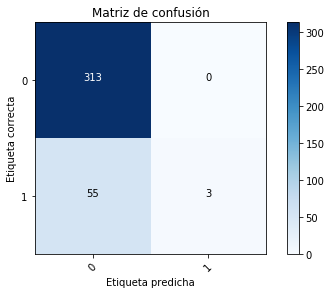

In [29]:
clf = SGDClassifier(random_state=2)
clf.fit(X_train, y_train)

print("Reporte de clasificación  (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

print("================================================", end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('0', '1'), title="Matriz de confusión")

#### Características del SGDClassifier 




El clasificador por descenso de gradiente (SGD classifier) tiene los siguientes parámetros:
* loss: el default es hinge implementa support vector machine lineal. 
* penalty: el valor predeterminado es ‘l2’, que es el regularizador estándar para modelos SVM lineales.
* alpha: Constante que multiplica el término de regularización. Defaults to 0.0001
* l1_ratio: l1_ratio=0 corresponde para L2 penalty
* fit_intercept: Si la intercepción debe ser estimada o no. Defaults es True.
* max_iter: El número máximo de pasadas sobre los datos de entrenamiento. default=1000
* tol: Criterio de stop del algoritmo. default=1e-3
* shuffle: Si los datos de entrenamiento se deben barajar o no después de cada época. Por defecto es True
* learning_rate : 
        * ‘constant’: eta = eta0
        * ‘optimal’: eta = 1.0 / (alpha * (t + t0)) donde t0 es elegido por una heurística propuesta por Leon Bottou.
        * ‘invscaling’: eta = eta0 / pow(t, power_t)
        * ‘adaptive’: eta = eta0,siempre y cuando el entrenamiento siga disminuyendo. Cada vez que n_iter_no_change épocas consecutivas no logran disminuir la pérdida de entrenamiento por tol o no logran aumentar la puntuación de validación por tol si la detención temprana es verdadera, la tasa de aprendizaje actual se divide entre 5.
        
* eta0: El valor predeterminado es 0.0 ya que eta0 no es usado por el programa predeterminado "óptimo".
* power_t El exponente para la tasa de aprendizaje de escala inversa (por defecto 0.5)
* early_stopping: Si se debe usar la detención temprana para finalizar el entrenamiento cuando la puntuación de validación no está mejorando. (default=False)
* validation_fraction:  La proporción de datos de entrenamiento que se deben reservar como validación establecida para una parada temprana. Debe estar entre 0 y 1. Solo se utiliza si la detención temprana es Verdadera. (default=0.1)
* n_iter_no_change: Número de iteraciones sin mejoría que esperar antes de una parada temprana. (default=5)

#### Significados de métricas de rendimiento


In [30]:
%%HTML
<style>
.div {margin-left: 25%;font-weight: bold;}
</style>

Teniendo en cuenta los siguientes conceptos:
* TP: True positive, la predicción es positiva y es positiva.
* TN: True Negative, la predicción es negativa y es negativa.
* FP: False Positive, la predicción es positiva pero es negativa.
* FN: False Negative, la prediccion es negativa pero es positiva.

Tenemos la siguientes métricas:
* Accuracy: proporción de los que han sido etiquetados correctamente. <br></br><div class='div'>Accuracy = (TP+TN)/(TP+FP+FN+TN)</div>
Accuracy: 0.8518. Esto significa que el 85% de los datos han sido etiquetados correctamente.

* Precision: - La precisión es la relación entre las observaciones positivas pronosticadas correctamente y el total de observaciones positivas pronosticadas. La pregunta que responde esta métrica:  de todos los pasajeros que etiquetaron como sobrevivientes, ¿cuántos sobrevivieron realmente?. <br></br><div class='div'>Precision = TP/(TP+FP)</div>
Precision: para label es 0 es 0.85 y para cuando label es 1 es 1

* Recall (Sensibilidad): Recall es la relación entre las observaciones positivas pronosticadas correctamente y todas las observaciones en la clase real, Verdadera. La respuesta a la pregunta que se responde es: De todos los pasajeros que realmente sobrevivieron, ¿cuántos etiquetamos? <br></br><div class='div'>Recall = TP / TP + FN</div>
rea

* F1: Es el promedio ponderado entre la presición y recall. Por lo tanto, esta puntuación tiene en cuenta tanto los falsos positivos como los falsos negativos. Intuitivamente, no es tan fácil de entender como la precisión, pero la F1 suele ser más útil que la precisión, especialmente si tiene una distribución de clases desigual. La precisión funciona mejor si los falsos positivos y los falsos negativos tienen un costo similar. Si el costo de los falsos positivos y los falsos negativos es muy diferente, es mejor tener en cuenta tanto la precisión como el recall. <br></br><div class='div'>F1 Score = 2*(Recall * Precision) / (Recall + Precision)</div>

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Exploración de hiperparámetros para función de coste "hinge"

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}

Puntajes de la grilla:

Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1

# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}

Puntajes de la grilla:

Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 

C:\Users\soluj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros para función de coste "perceptron"

Mejor conjunto de parámetros:
{'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l2'}

Puntajes de la grilla:

Exactitud: 0.834 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Exactitud: 0.858 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}
Exactitud: 0.698 (+/-0.070) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
Exactitud: 0.850 (+/-0.000) para los parámetros {'alpha':

# Exploración de hiperparámetros para función de coste "modified_huber"

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}

Puntajes de la grilla:

Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'constant', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l2'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'l1'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.1, 'eta0': 0.1, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'al

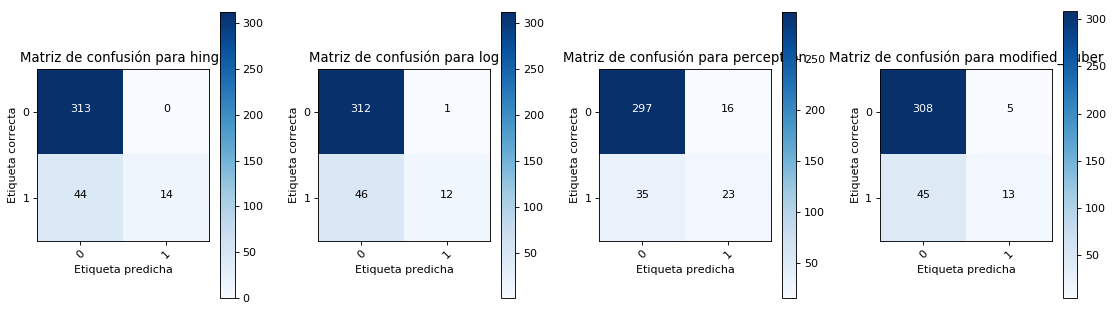

In [31]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

for idx, loss in enumerate(('hinge', 'log', 'perceptron','modified_huber'), start=1):
    exploring_params = {
        'learning_rate': ['constant','optimal','invscaling','adaptive'],
        'eta0': [0.1, 0.01, 0.001],  # Tasa de entrenamiento/ tamaño del paso
        'alpha': [0.1, 0.01, 0.001],  # Tasa de regularización
        'penalty': ['l2', 'l1','elasticnet']
    }
    m = SGDClassifier(loss=loss, tol=1e-3,random_state=2)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred), end="\n\n")
    print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
    print("================================================", end="\n\n")

    plt.subplot(1, 4, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=('0', '1'), title="Matriz de confusión para %s" % loss)

## Ejercicio 3: Árbol de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

In [32]:
# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Reporte de clasificación  (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       313
           1       0.67      0.59      0.62        58

   micro avg       0.89      0.89      0.89       371
   macro avg       0.80      0.77      0.78       371
weighted avg       0.88      0.89      0.89       371



Accuracy: 0.8895


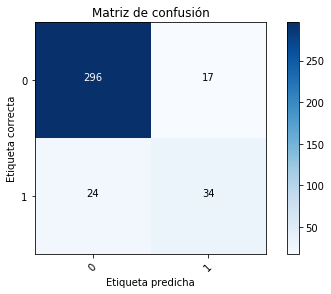

In [33]:

clf = tree.DecisionTreeClassifier(random_state=1)
fit = clf.fit(X_train, y_train)

print("Reporte de clasificación  (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))

plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('0', '1'), title="Matriz de confusión")





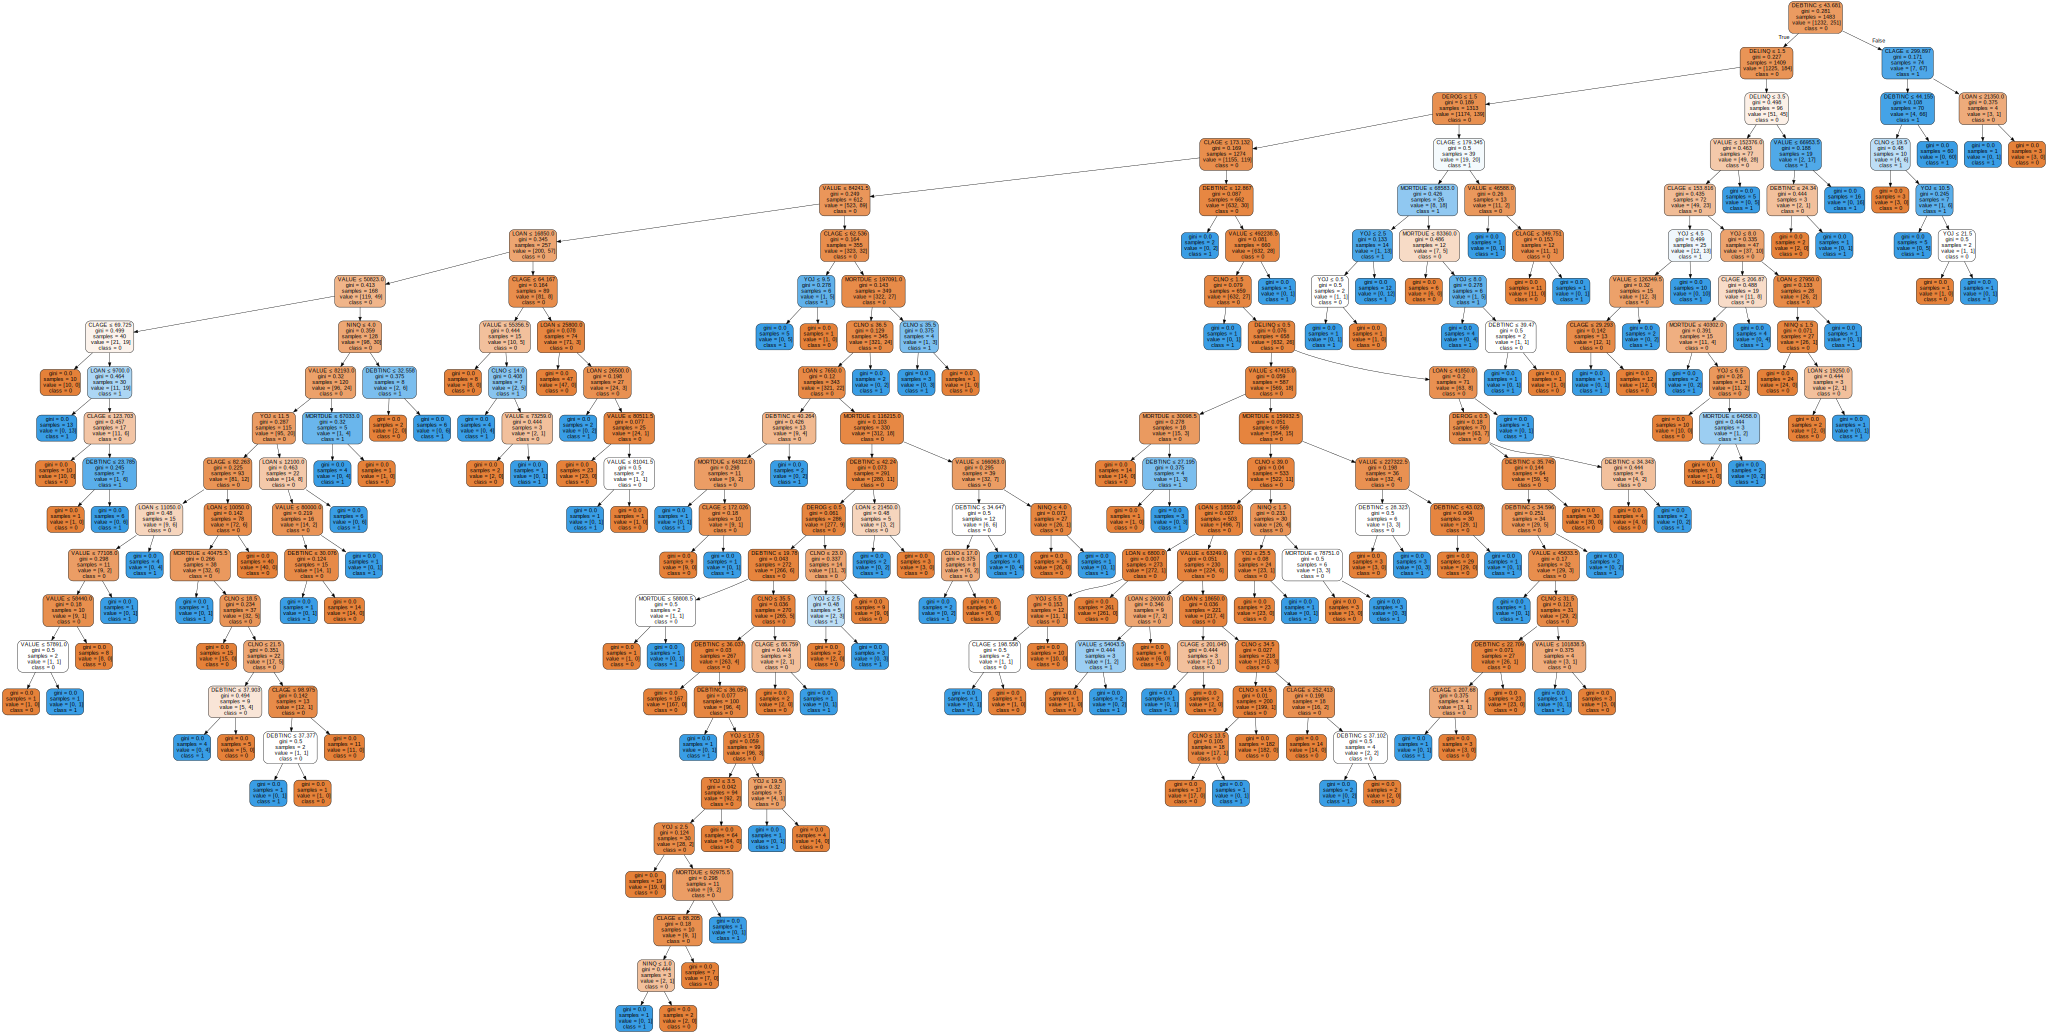

In [34]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=dataset.columns[1:],  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Exploración de hiperparámetros para función de coste "modified_huber"

Mejor conjunto de parámetros:
{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10}

Puntajes de la grilla:

Exactitud: 0.872 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1}
Exactitud: 0.873 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10}
Exactitud: 0.871 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 50}
Exactitud: 0.877 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}
Exactitud: 0.879 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10}
Exactitud: 0.871 (+/-0.000) para los parámetros {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 50}
Exactitud: 0.862 (+/-0.001) para los parámetros {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1}
Exactitud: 0.877 (+/-0.000) para los parám

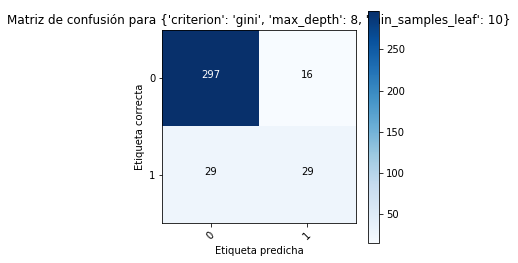

In [35]:

exploring_params = {
    'max_depth':[2,8,16,54],
    'min_samples_leaf':[1,10,50],
    'criterion': ['gini', 'entropy']
}
m = tree.DecisionTreeClassifier(random_state=1)
model = GridSearchCV(m, exploring_params,cv=5)
model.fit(X_train, y_train)

print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))


print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")
print("Accuracy: %0.4f" % accuracy_score(y_true, y_pred))
print("================================================", end="\n\n")


plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=('0', '1'), title="Matriz de confusión para %s" % model.best_params_)

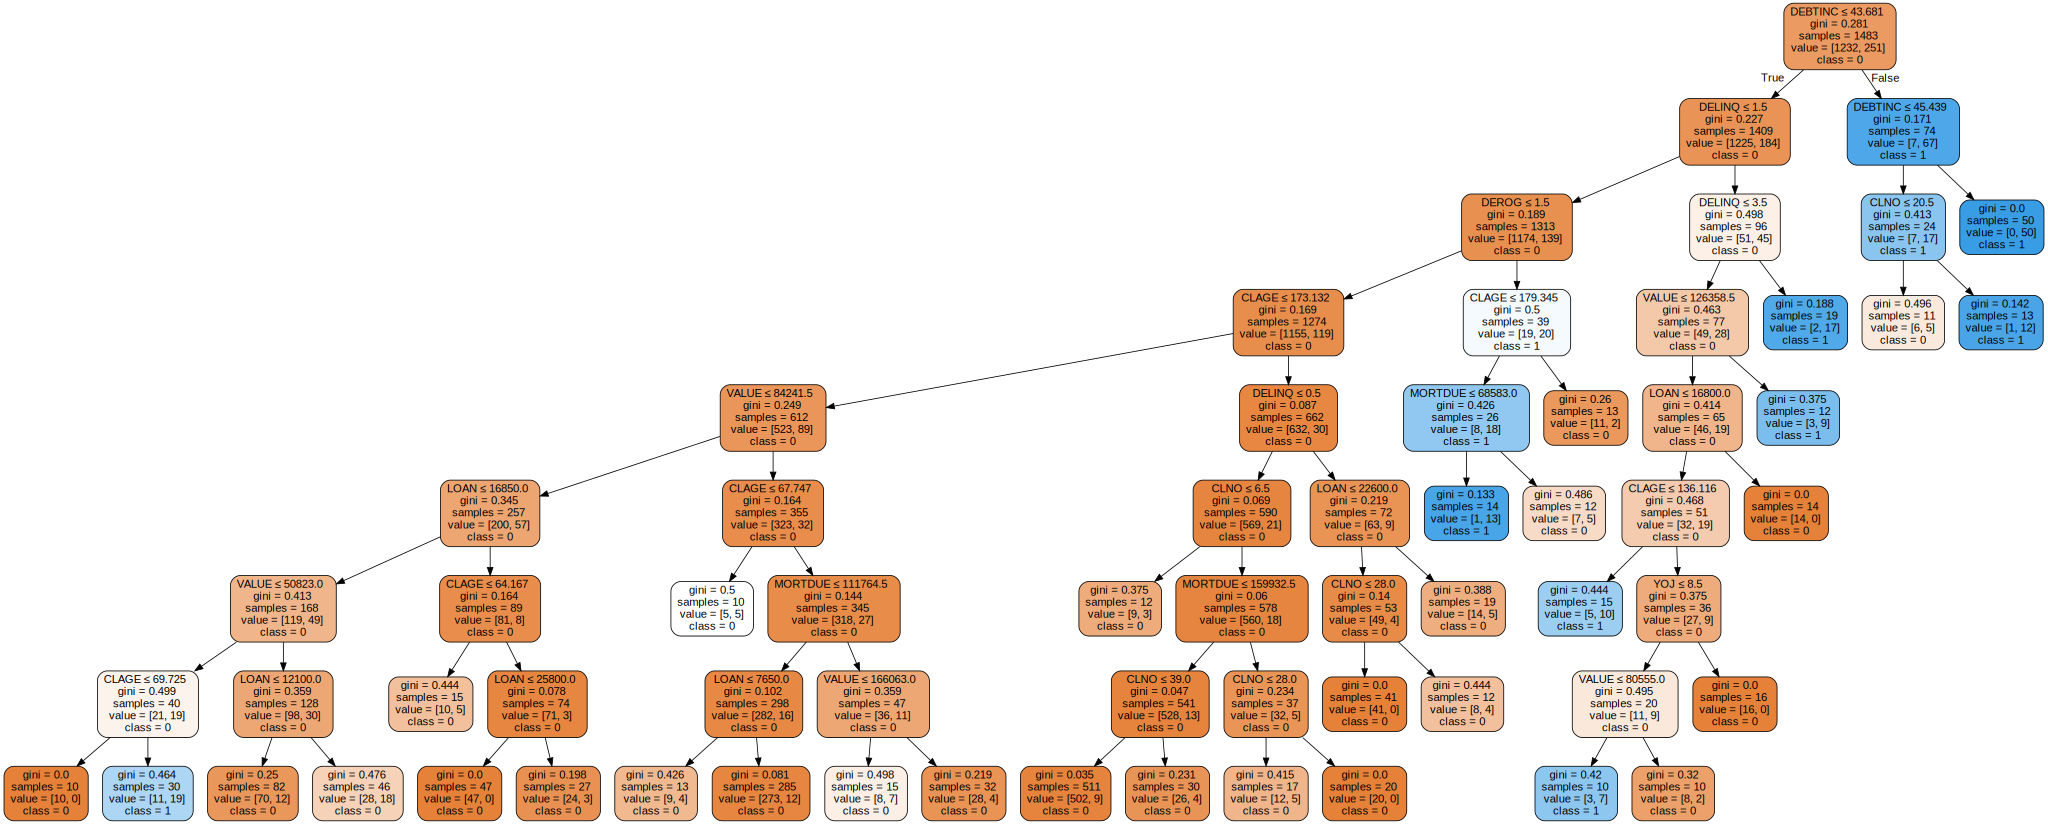

In [36]:
dot_data = tree.export_graphviz(model.best_estimator_, out_file=None, 
                         feature_names=dataset.columns[1:],  
                         class_names=['0','1'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph